## Task a) Define SQLAlchemy ORM Entities
Use SQLAlchemy ORM to define and store two entities:
- Person: Represents each individual in the network.
- Acquaintance: Represents the direct relationships between two individuals (Person to Person).

The relationship between the two entities is defined, where a Person can have multiple acquaintances. This will help understand how social connections can influence virus spread in the context of the previous cluster analysis.

People = Parent // Acquintance = Child

In [3]:
import sqlite3

In [4]:
# creating database for people

conn = sqlite3.connect('person_acquaintance.db')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS person')
cur.execute('CREATE TABLE person (_id TEXT PRIMARY KEY, name TEXT)')

# creating table  for acquaintance
cur.execute('DROP TABLE IF EXISTS acquaintance')
cur.execute('CREATE TABLE acquaintance (acquaintance_index INTEGER PRIMARY KEY AUTOINCREMENT, from_id TEXT, to_id TEXT, FOREIGN KEY (from_id) REFERENCES person(_id))')

conn.commit()

In [5]:
import csv 

with open('../data/people.csv') as f:
    reader = csv.reader(f)
    next(reader, None)
    read_count = 0 
    for row in reader:
        read_count += 1
        ID = row[0]
        name = row[1]
        # after we clean up and have the data ready we insert it into table accordingly
        cur.execute('INSERT INTO person (_id, name) VALUES (?, ?)',(ID, name))
    conn.commit()
    cur.execute('SELECT COUNT(*) FROM person')
    row_count = cur.fetchone()[0] #take out only 1st element
    assert row_count == read_count # no error

In [6]:
with open('../data/acquaintance.csv') as g:
    reader = csv.reader(g)
    next(reader, None)
    read_count = 0 
    for row in reader:
        read_count += 1
        c1 = row[0]
        c2 = row[1]
        # after we clean up and have the data ready we insert it into table accordingly
        cur.execute('INSERT INTO acquaintance (from_id, to_id) VALUES (?, ?)',(c1, c2))
    conn.commit()
    cur.execute('SELECT COUNT(*) FROM acquaintance')
    row_count = cur.fetchone()[0] #take out only 1st element
    assert row_count == read_count # no error

In [7]:
conn.close()

In [8]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Enum, Float,ForeignKey
from sqlalchemy.orm import relationship
Base = declarative_base()

class Person(Base):
    __tablename__ = 'person'
    
    _id = Column(String, primary_key=True)
    name = Column(String)
    _acquaintance = relationship('Acquaintance', backref='_person')
    
    def __repr__(self):
        return "%s %s" %(self._id, self.name)

class Acquaintance(Base):
    __tablename__ = 'acquaintance'
    
    acquaintance_index = Column(Integer, primary_key=True)
    from_id = Column(String,  ForeignKey('person._id'))
    to_id = Column(String)
    
    def __repr__(self):
        return "%s %s %s" %(self.acquaintance_index, self.from_id, self.to_id)

In [9]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///person_acquaintance.db', echo= False)

Base.metadata.create_all(engine)
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

## Task b) Find Direct Acquaintances
Compose the necessary queries and define a function using SQLAlchemy ORM that:
- Takes a **person ID** as a parameter.
- Returns all **direct acquaintances** of that person (i.e., people who have a direct relationship with the given person ID).

**Direct relationship**: A direct edge between two people (e.g., `A <-> B`), representing potential transmission paths for the virus.

In [10]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Enum, Float,ForeignKey, func
from sqlalchemy.orm import relationship
Base = declarative_base()

class Person(Base):
    __tablename__ = 'person'
    
    _id = Column(String, primary_key=True)
    name = Column(String)
    _acquaintance = relationship('Acquaintance', backref='_person')
    
    def GetName(self, session, ID):
        result = session.query(Person).filter(Person._id == ID)
        return result.name
    
    def __repr__(self):
        return "%s %s" %(self._id, self.name)

class Acquaintance(Base):
    __tablename__ = 'acquaintance'
    
    acquaintance_index = Column(Integer, primary_key=True)
    from_id = Column(String,  ForeignKey('person._id'))
    to_id = Column(String)
    
    def __repr__(self):
        return "%s %s %s" %(self.acquaintance_index, self.from_id, self.to_id)

In [11]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///person_acquaintance.db', echo= False)

Base.metadata.create_all(engine)
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

In [12]:
def GetAcquaintanceName(personID):
    AcquaintanceIDList = []
    VerifiedAcquaintanceList = []
    DirectAcquaintanceNameList = []
    result = session.query(Acquaintance).filter(Acquaintance.from_id == personID)
    for r in result:
        AcquaintanceIDList.append(str(r.to_id))
        
    for u in range(len(AcquaintanceIDList)):
        IDToVerify = str(AcquaintanceIDList[u])
        verification = session.query(Acquaintance).filter(Acquaintance.from_id == IDToVerify).filter(Acquaintance.to_id == personID)
        for v in verification:
            VerifiedAcquaintanceList.append(v.from_id)
    for i in VerifiedAcquaintanceList:
        names = result = session.query(Person).filter(Person._id == i)
        for n in names:
            DirectAcquaintanceNameList.append(n.name)
    return DirectAcquaintanceNameList

In [13]:
GetAcquaintanceName('PERSON_0000000067')

['Michael Peters',
 'Tracy Rodriguez',
 'Christopher Campbell',
 'Melissa Pacheco',
 'Mr. Jack Miller',
 'Kenneth Adams',
 'Edward Solis',
 'Catherine Thomas',
 'Sharon Obrien',
 'Jeffrey King',
 'Zachary Casey',
 'Rachel Rodriguez',
 'Mary Wilson',
 'Carla Lambert',
 'James Dean']

## Task c) Count and Visualise Acquaintances
(i) **Count the number of acquaintances per person** using SQLAlchemy ORM.

In [14]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def NumOfAcqPerPerson():
    ListOfPeople = []
    NoOfAcqResult = []
    result = session.query(Person)
    for r in result: ListOfPeople.append(r._id)
    for index in ListOfPeople:
        NoOfAcq = session.query(Acquaintance).filter(Acquaintance.from_id == index).count()
        NoOfAcqResult.append(NoOfAcq)

    DictNumOfAcqPerPerson = dict(zip(ListOfPeople, NoOfAcqResult))
    return DictNumOfAcqPerPerson

In [16]:
NumOfAcqPerPerson()

{'PERSON_0000000000': 14,
 'PERSON_0000000001': 12,
 'PERSON_0000000002': 18,
 'PERSON_0000000003': 13,
 'PERSON_0000000004': 19,
 'PERSON_0000000005': 23,
 'PERSON_0000000006': 22,
 'PERSON_0000000007': 15,
 'PERSON_0000000008': 17,
 'PERSON_0000000009': 14,
 'PERSON_0000000010': 16,
 'PERSON_0000000011': 27,
 'PERSON_0000000012': 18,
 'PERSON_0000000013': 24,
 'PERSON_0000000014': 14,
 'PERSON_0000000015': 21,
 'PERSON_0000000016': 15,
 'PERSON_0000000017': 12,
 'PERSON_0000000018': 17,
 'PERSON_0000000019': 11,
 'PERSON_0000000020': 21,
 'PERSON_0000000021': 15,
 'PERSON_0000000022': 22,
 'PERSON_0000000023': 25,
 'PERSON_0000000024': 28,
 'PERSON_0000000025': 17,
 'PERSON_0000000026': 19,
 'PERSON_0000000027': 27,
 'PERSON_0000000028': 22,
 'PERSON_0000000029': 12,
 'PERSON_0000000030': 26,
 'PERSON_0000000031': 16,
 'PERSON_0000000032': 10,
 'PERSON_0000000033': 22,
 'PERSON_0000000034': 20,
 'PERSON_0000000035': 18,
 'PERSON_0000000036': 22,
 'PERSON_0000000037': 17,
 'PERSON_000

## (c) Count and Visualise Acquaintances
(ii) **Draw a boxplot** to display the distribution of the number of acquaintances per person. This is crucial for understanding the network structure and the likelihood of individuals being exposed to the virus through social interactions.

In [17]:
data_items = NumOfAcqPerPerson().items()
data_list = list(data_items)
NumOfAcqPerPersonDF = pd.DataFrame(data_list, columns =['person', 'no_of_acquaintances'])

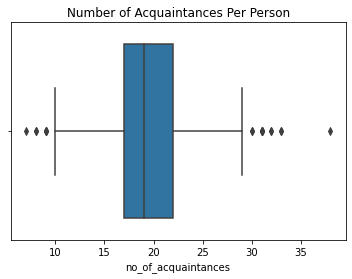

In [19]:
plot = sns.boxplot(x=NumOfAcqPerPersonDF['no_of_acquaintances'])
plot.axes.set_title("Number of Acquaintances Per Person", fontsize=12)
plt.show()

## Task d) Find People with Most Acquaintances
Use SQLAlchemy ORM to find the **names of people** who have the most acquaintances. These individuals are more likely to be central nodes in the network and could play a key role in spreading the virus within clusters.

In [20]:
def MostAcquaintancePeopleName():
    ListOfPeople = []
    NoOfAcqResult = []
    MostAcquaintancePeopleName = []
    MaxValue = 0
    result = session.query(Person)
    for r in result: ListOfPeople.append(r._id)
    for index in ListOfPeople:
        NoOfAcq = session.query(Acquaintance).filter(Acquaintance.from_id == index).count()
        if NoOfAcq > MaxValue: 
            MaxValue = NoOfAcq
        NoOfAcqResult.append(NoOfAcq)
    DictNumOfAcqPerPerson = dict(zip(ListOfPeople, NoOfAcqResult))
    MostAcquaintancePeopleIndex = [index for index, value in DictNumOfAcqPerPerson.items() if value == MaxValue]
    for personIndex in MostAcquaintancePeopleIndex:
        name = session.query(Person).filter(Person._id == personIndex)
        for n in name:
            MostAcquaintancePeopleName.append(n.name)
    return MostAcquaintancePeopleName

In [21]:
MostAcquaintancePeopleName()

['George Anderson']

## Task e) Find Groups of Three People Who Know Each Other
Use SQLAlchemy ORM to find all groups of three distinct people who all know each other. This could help identify tightly-knit groups in the network that may experience more rapid virus transmission, further influencing cluster development.

In [22]:
def GetGroupsof3():
    ListOfPeople = []
    Groupsof3List = []
    result = session.query(Person)
    for r in result: ListOfPeople.append(r._id)
    for index in ListOfPeople:
        A_Acq = session.query(Acquaintance).filter(Acquaintance.from_id == index)
        for a in A_Acq:
            B_Acq = session.query(Acquaintance).filter(Acquaintance.from_id == a.to_id)
            for b in B_Acq:
                C_Acq = session.query(Acquaintance).filter((Acquaintance.from_id == b.to_id)&(Acquaintance.to_id == index))
                for c in C_Acq:
                    Groupsof3List.append([a.from_id, b.from_id, c.from_id])
    Groupsof3List_noDupli = list(set(tuple(sorted(item)) for item in Groupsof3List))
    return Groupsof3List_noDupli

In [ ]:
GetGroupsof3()[:6]